### Crate Tensorflow Estimator Class and Train it locally

In [1]:
PROJECT_ID = 'jchavezar-demo'
NUM_NEURONS = 32
L_RATE = 0.001
EPOCHS = 10
TRAIN_START_DATE = "20160801"
TRAIN_END_DATE = "20170430"

In [2]:
from src import Estimator

VertexTF = Estimator.VertexTF(
    project_id=PROJECT_ID,
    epochs=10
)
train, val, test = VertexTF.query(start_date=TRAIN_START_DATE, end_date=TRAIN_END_DATE)

In [3]:
## Prepare data by splitting, shuffling, transform to tensors, normalize and encode categorical values.

train_ds, val_ds, test_ds = VertexTF.preprocessing(target_column='will_buy_on_return_visit')

2022-10-17 14:16:02.952581: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-10-17 14:16:02.955685: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-17 14:16:02.955695: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/jesusarguelles/code/vertex-gpu/pipe_notebook/src/data/Transform.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in datafram

In [4]:
model = VertexTF.create_model(nn_input=NUM_NEURONS, lr=L_RATE)

In [5]:
model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds)

Epoch 1/10


/home/jesusarguelles/miniconda3/envs/gcp/lib/python3.7/site-packages/keras/engine/functional.py:566: UserWarning: Input dict contained keys ['will_buy_on_return_visit', 'source', 'medium', 'channelGrouping', 'deviceCategory'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


14325/14325 [==============================] - 18s 1ms/step - loss: 0.0657 - accuracy: 0.9845 - val_loss: 0.0582 - val_accuracy: 0.9849
Epoch 2/10
14325/14325 [==============================] - 20s 1ms/step - loss: 0.0599 - accuracy: 0.9846 - val_loss: 0.0582 - val_accuracy: 0.9849
Epoch 3/10
14325/14325 [==============================] - 19s 1ms/step - loss: 0.0596 - accuracy: 0.9846 - val_loss: 0.0587 - val_accuracy: 0.9849
Epoch 4/10
14325/14325 [==============================] - 17s 1ms/step - loss: 0.0596 - accuracy: 0.9846 - val_loss: 0.0581 - val_accuracy: 0.9849
Epoch 5/10
14325/14325 [==============================] - 19s 1ms/step - loss: 0.0596 - accuracy: 0.9846 - val_loss: 0.0584 - val_accuracy: 0.9849
Epoch 6/10
14325/14325 [==============================] - 19s 1ms/step - loss: 0.0597 - accuracy: 0.9846 - val_loss: 0.0583 - val_accuracy: 0.9849
Epoch 7/10
14325/14325 [==============================] - 18s 1ms/step - loss: 0.0595 - accuracy: 0.9846 - val_loss: 0.0582 - val

In [6]:
loss, accuracy = model.evaluate(test_ds)

1791/1791 [==============================] - 2s 929us/step - loss: 0.0578 - accuracy: 0.9855


In [7]:
train

,will_buy_on_return_visit,latest_ecommerce_progress,bounces,time_on_site,pageviews,source,medium,channelGrouping,deviceCategory,country
54189,0,0,0,102,3,youtube.com,referral,Social,desktop,Serbia
419658,0,0,1,0,1,google,organic,Organic Search,mobile,(not set)
263645,0,0,0,4,2,google,organic,Organic Search,desktop,United States
134114,0,0,1,0,1,(direct),(none),Direct,mobile,United States
525196,0,0,1,0,1,google,organic,Organic Search,desktop,United Kingdom
...,...,...,...,...,...,...,...,...,...,...
228818,0,2,0,1908,12,mall.googleplex.com,referral,Referral,desktop,United States
122519,0,0,0,51,2,youtube.com,referral,Social,desktop,Vietnam
494629,0,0,1,0,1,(direct),(none),Direct,mobile,United States
516989,0,5,0,422,15,(direct),(none),Direct,desktop,United States


<AxesSubplot:>

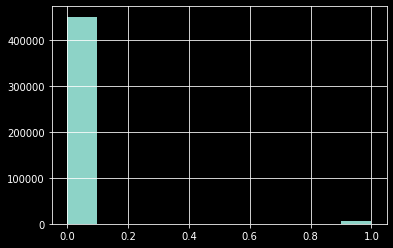

In [8]:
train['will_buy_on_return_visit'].hist()

### Create Container with Code and Train it with Vertex AI

In [12]:
TRAIN_IMAGE_URI = 'gcr.io/jchavezar-demo/visitor-purchase-train-ml:draft'

In [19]:
!rm -fr bqml_tf_keras
!mkdir bqml_tf_keras
!mkdir bqml_tf_keras/src
!cp -r src/* bqml_tf_keras/src/

In [47]:
%%writefile bqml_tf_keras/main.py
import os
import warnings
import argparse
from src import Estimator
warnings.filterwarnings('ignore')

TRAIN_START_DATE = "20160801"
TRAIN_END_DATE = "20170430"

def get_args():
    '''Parses args. Must include all hyperparameters you want to tune.'''
    parser = argparse.ArgumentParser()
    parser.add_argument(
        '--batch_size',
        default=32,
        type=int,
        help='batch size to build tf.data.Dataset')
    parser.add_argument(
        '--num_neurons',
        default=32,
        type=int,
        help='The number of neural neurons in the first layer'
        )
    parser.add_argument(
        '--learning_rate',
        default=0.001,
        type=float,
        help='number of units in the first hidden layer')
    parser.add_argument(
        '--epochs',
        default=10,
        type=int,
        help='The number of training iterations over the entire dataset'
        )
    parser.add_argument(
        '--label_column',
        default='will_buy_on_return_visit',
        type=str,
        help='The column to be predicted'
        )
    args = parser.parse_args()
    return args

def main():
    args = get_args()
    VertexTF = Estimator.VertexTF(
        project_id=os.environ['CLOUD_ML_PROJECT_ID'],
        epochs=args.epochs
        )
    train, val, test = VertexTF.query(start_date=TRAIN_START_DATE, end_date=TRAIN_END_DATE)
    train_ds, val_ds, test_ds = VertexTF.preprocessing(target_column=args.label_column)
    model = VertexTF.create_model(nn_input=args.num_neurons, lr=args.learning_rate)
    print(train_ds)
    history = model.fit(train_ds, epochs=args.epochs, validation_data=val_ds)

    hp_metric = history.history['val_accuracy'][-1]
    print(hp_metric)

if __name__ == "__main__":
    main()

Overwriting bqml_tf_keras/main.py


In [24]:
%%writefile bqml_tf_keras/Dockerfile

FROM tensorflow/tensorflow

RUN pip install google-cloud-bigquery==2.34.4 \
    && pip install pandas \
    && pip install protobuf==3.19.4 \
    && pip install pyarrow \
    && pip install cloudml-hypertune

COPY . /

ENTRYPOINT ["python", "main.py"]

Overwriting bqml_tf_keras/Dockerfile


### Cloud Build to Create and Push Image to Google Cloud Repository

In [16]:
!gcloud builds submit -t gcr.io/jchavezar-demo/visitor-purchase-train-ml:draft bqml_tf_keras/.

Creating temporary tarball archive of 11 file(s) totalling 22.0 KiB before compression.
Uploading tarball of [bqml_tf_keras/.] to [gs://jchavezar-demo_cloudbuild/source/1666030914.585788-3b9bfa3891d94a3b92238d097cc1f136.tgz]
Created [https://cloudbuild.googleapis.com/v1/projects/jchavezar-demo/locations/global/builds/865d915f-8aae-4ef7-9df5-5f11f6fa4308].
Logs are available at [ https://console.cloud.google.com/cloud-build/builds/865d915f-8aae-4ef7-9df5-5f11f6fa4308?project=569083142710 ].
----------------------------- REMOTE BUILD OUTPUT ------------------------------
starting build "865d915f-8aae-4ef7-9df5-5f11f6fa4308"

FETCHSOURCE
Fetching storage object: gs://jchavezar-demo_cloudbuild/source/1666030914.585788-3b9bfa3891d94a3b92238d097cc1f136.tgz#1666030914970556
Copying gs://jchavezar-demo_cloudbuild/source/1666030914.585788-3b9bfa3891d94a3b92238d097cc1f136.tgz#1666030914970556...
/ [1 files][  7.0 KiB/  7.0 KiB]                                                
Operation completed 

### Run the Custom Training Job on Vertex AI

In [ ]:
from google.cloud import aiplatform
from google.cloud.aiplatform import hyperparameter_tuning as hpt

aiplatform.init(project='jchavezar-demo', location='us-central1', staging_bucket='gs://vtx-staging')

worker_pool_specs = [
    {
        "machine_spec": {
            "main
    himachine_type": "n1-standard-4",
        },
        "replica_count": 1,
        "container_spec": {
            "image_uri": "gcr.io/jchavezar-demo/visitor-purchase-train-ml:latest",
            "command": [],
            "args": ["--hptune","True"],
        },
    }
]

custom_job = aiplatform.CustomJob(
    display_name='custom_job',
    worker_pool_specs=worker_pool_specs,
)

hpt_job = aiplatform.HyperparameterTuningJob(
    display_name='purchase-hpt',
    custom_job=custom_job,
    metric_spec={
        'loss': 'minimize',
    },
    parameter_spec={
        'learning_rate': hpt.DoubleParameterSpec(min=0.001, max=0.1, scale='log'),
        'num_neurons': hpt.IntegerParameterSpec(min=4, max=128, scale='linear'),
        'batch_size': hpt.DiscreteParameterSpec(values=[128, 256], scale='linear')
    },
    max_trial_count=128,
    parallel_trial_count=8,
    labels={'hpt_test': 'jca'},
    )

hpt_job.run()